In [1]:

import numpy as np 
import pandas as pd 


In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.pipeline import Pipeline

import seaborn as sns, matplotlib.pyplot as plt

import re

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [4]:
# Fake News loaded
fake = pd.read_csv('Fake.csv')
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
# Fake news are labelled as 1
fake['label'] = 1
fake.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [6]:
fake.text[0]

'Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t ev

In [7]:
# True news loaded
true = pd.read_csv('True.csv')
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [8]:
# True news labelled as 0
true['label'] = 0
true.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [9]:
len(true), len(fake)

(21417, 23481)

In [10]:
# Both fake and true news are combined and first 2000 data points are only selected
df = pd.concat([fake.iloc[:,:],true.iloc[:,:]], axis=0)
df = df.sample(len(df))
df = df.reset_index(drop=True)
df.head()

,title,text,subject,date,label
0,"Daughter Chelsea casts Clinton as great mom, d...",PHILADELPHIA (Reuters) - Chelsea Clinton took ...,politicsNews,"July 29, 2016",0
1,New Obama Rule Will STOP Republicans From Def...,Republicans hate it. They really really hate i...,News,"September 9, 2016",1
2,Russia won't hand over suspect in Montenegro c...,MOSCOW (Reuters) - Russia will not hand over t...,worldnews,"November 1, 2017",0
3,Republicans Just Moved To Repeal Obamacare. T...,President Barack Obama accomplished many great...,News,"January 12, 2017",1
4,Venezuela's Maduro strips rival of U.N. post a...,CARACAS/HOUSTON (Reuters) - Venezuela has orde...,worldnews,"November 29, 2017",0


In [11]:
df

,title,text,subject,date,label
0,"Daughter Chelsea casts Clinton as great mom, d...",PHILADELPHIA (Reuters) - Chelsea Clinton took ...,politicsNews,"July 29, 2016",0
1,New Obama Rule Will STOP Republicans From Def...,Republicans hate it. They really really hate i...,News,"September 9, 2016",1
2,Russia won't hand over suspect in Montenegro c...,MOSCOW (Reuters) - Russia will not hand over t...,worldnews,"November 1, 2017",0
3,Republicans Just Moved To Repeal Obamacare. T...,President Barack Obama accomplished many great...,News,"January 12, 2017",1
4,Venezuela's Maduro strips rival of U.N. post a...,CARACAS/HOUSTON (Reuters) - Venezuela has orde...,worldnews,"November 29, 2017",0
...,...,...,...,...,...
44893,China says hopes Iran nuclear deal stays intac...,BEIJING (Reuters) - China said on Monday it ho...,worldnews,"October 9, 2017",0
44894,Trump Loses His Sh*t Over SNL Skit And Alec B...,"Once again, Donald Trump threw a temper tantru...",News,"November 20, 2016",1
44895,No Longer Just Suspicion: Experts Trace DNC H...,Rumors that the DNC hack was tied to Russia ha...,News,"July 26, 2016",1
44896,"“MIC DROP!” A Lady Approached Sheriff Clarke, ...",Here is his epic response to her criticism: La...,politics,"Feb 17, 2017",1


In [12]:
# Text & Title columns are combined and other columns except label are dropped
df.text = df.title + df.text
df = df[['text','label']]
df.head()

,text,label
0,"Daughter Chelsea casts Clinton as great mom, d...",0
1,New Obama Rule Will STOP Republicans From Def...,1
2,Russia won't hand over suspect in Montenegro c...,0
3,Republicans Just Moved To Repeal Obamacare. T...,1
4,Venezuela's Maduro strips rival of U.N. post a...,0


In [14]:
X = df.text
y = df.label

# Processing 
    classification 

In [15]:
# Data processing is done
corpus = []
ps = PorterStemmer()

for i in X:
    # Except alphabets, everything is removed
    new = re.sub('[^a-zA-Z]', ' ',i)
    # Converted to lower case
    new = new.lower()
    # Word tolenizing done
    new = nltk.word_tokenize(new)
    # English stop words are removed
    new = [ps.stem(i) for i in new if i not in stopwords.words('english')]
    new = ' '.join(new)
    corpus.append(new)

In [16]:
# Splitting into train and test data
X_train,X_test, y_train,y_test = train_test_split(corpus,y, train_size=0.7, random_state=100, stratify=y)

In [17]:
# 2 models are considered included in a pipeline to produce bag of words
mnb = Pipeline([('cnt_vec', CountVectorizer()),
               ('mnb', MultinomialNB())])

bnb = Pipeline([('cnt_vec', CountVectorizer()),
               ('bnb', BernoulliNB())])

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=52)

In [18]:
# Cross validation for first model
cv_mnb = cross_val_score(mnb,X_train,y_train,cv=folds)
cv_mnb.mean()

0.9508082944230096

In [19]:
# Cross validation for second model
cv_bnb = cross_val_score(bnb,X_train,y_train,cv=folds)
cv_bnb.mean()

0.9659539414151892

In [20]:
# Hyperparameter tuning to find the best model and parameters
classifier = Pipeline([('classifier', mnb)])

hyp = [{'classifier':[mnb],
       'classifier__cnt_vec__ngram_range':[(1,1),(1,2),(2,1),(2,2)]},
      {'classifier':[bnb],
       'classifier__cnt_vec__ngram_range':[(1,1),(1,2),(2,1),(2,2)]}]

grid = GridSearchCV(estimator=classifier, param_grid=hyp, cv=folds, n_jobs=-1, scoring='accuracy',
                   verbose=3, return_train_score=True)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\x1doo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.95080829 0.9696768         nan 0.97581779 0.96595394 0.97858604
        nan 0.97744054]
  warnings.warn(
C:\Users\x1doo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the train scores are non-finite: [0.95982086 0.99472604        nan 0.99856816 0.97284269 0.99760564
        nan 0.99893407]
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=52, shuffle=True),
             estimator=Pipeline(steps=[('classifier',
                                        Pipeline(steps=[('cnt_vec',
                                                         CountVectorizer()),
                                                        ('mnb',
                                                         MultinomialNB())]))]),
             n_jobs=-1,
             param_grid=[{'classifier': [Pipeline(steps=[('cnt_vec',
                                                          CountVectorizer()),
                                                         ('mnb',
                                                          MultinomialNB())])],
                          'classifier__cnt_vec__ngram_range': [(1, 1), (1, 2),
                                                               (2, 1),
                                                               (2, 2)]},
                         {'classifier': [Pi

In [21]:
grid.best_estimator_, grid.best_score_

(Pipeline(steps=[('classifier',
                  Pipeline(steps=[('cnt_vec',
                                   CountVectorizer(ngram_range=(1, 2))),
                                  ('bnb', BernoulliNB())]))]),
 0.9785860359207653)

In [22]:
model = grid.best_estimator_

In [23]:
# Final training of model
model.fit(X_train,y_train)
y_test_pred = model.predict(X_test)
print('Accuracy of test data =',100*accuracy_score(y_test, y_test_pred),'%')
print('Recall of test data =',100*recall_score(y_test, y_test_pred),'%')
print('Precision  of test data =',100*precision_score(y_test, y_test_pred),'%')
print('F1  of test data =',100*f1_score(y_test, y_test_pred),'%')


Accuracy of test data = 98.04008908685968 %
Recall of test data = 97.98438608942513 %
Precision  of test data = 98.26334519572953 %
F1  of test data = 98.12366737739872 %


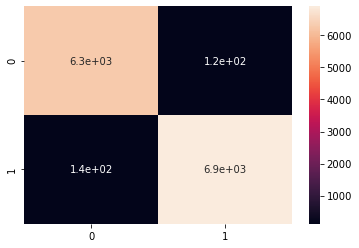

In [24]:
conf = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf, annot=True)
plt.show()

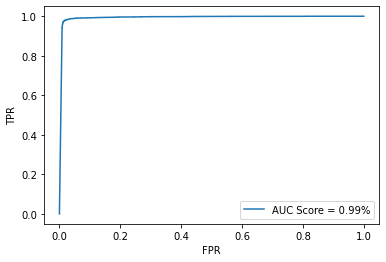

In [25]:
y_test_proba = [i[1] for i in model.predict_proba(X_test)]

auc = roc_auc_score(y_test,y_test_proba)
fpr,tpr,thresh = roc_curve(y_test,y_test_proba)
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(('AUC Score = {}%'.format(round(auc,2)),),loc='lower right')
plt.show()

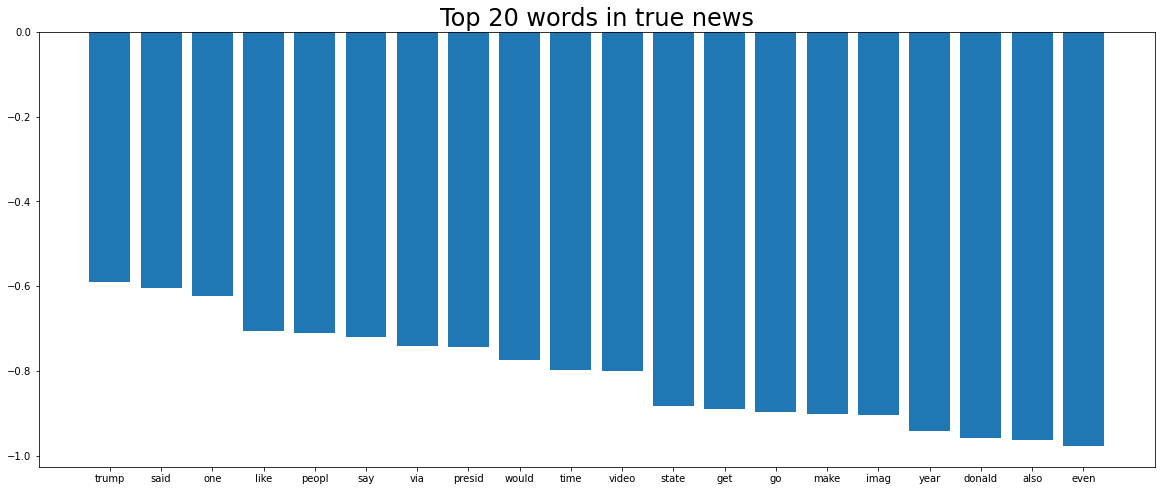

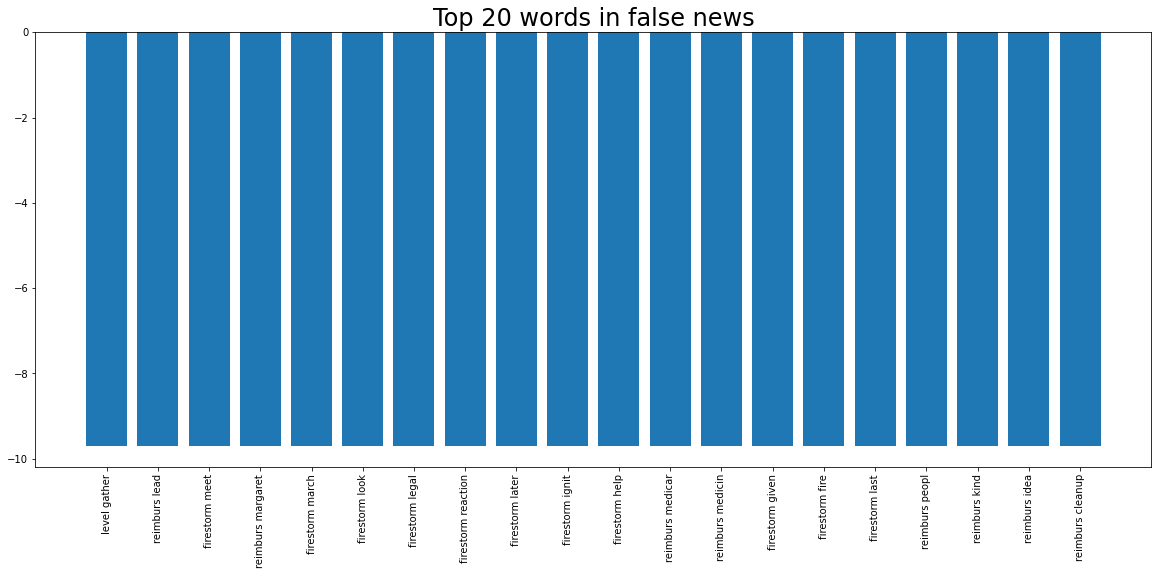

In [29]:
imp = pd.DataFrame({'features':model['classifier']['cnt_vec'].get_feature_names(), 'coef':model['classifier']['bnb'].coef_[0]})

top20 = imp.sort_values('coef',ascending=False).iloc[:20,:]
down20 = imp.sort_values('coef').iloc[:20,:]

plt.figure(figsize=(20,8))
plt.bar(top20.features,top20.coef)
plt.title('Top 20 words in true news', fontsize=24)
plt.show()

plt.figure(figsize=(20,8))
plt.bar(down20.features,down20.coef)
plt.title('Top 20 words in false news', fontsize=24)
plt.xticks(rotation=90)
plt.show()

# Topic modeling